In [1]:
# Predictive model for cardiac events risk prediction
# Author: Yichun Zhao

# Codes adapted from the R scripts from Rob Balshaw

In [36]:
library(tidyverse)
library(broom)
library(here)
library(plotROC)
library(VIM)
library(splines)
library(modelr)
library(skimr)

# Dataset loading, processing, and quality assessment

In [3]:
# dataset: 558 obs

# bhr - Basal heart rate
# basebp - Basal blood pressure
# basedp - Basal Double Product bhr*basebp
# pkhr - Peak heart rate
# sbp - Systolic blood pressure
# dp - Double product pkhr*sbp
# dose - Dose of dobutamine given
# maxhr - Maximum heart rate
# pctMphr - Percent maximum predicted heart rate achieved
# mbp - Maximum blood pressure
# dpmaxdo - Double product on max dobutamine dose
# dobdose - Dobutamine dose at max double product
# age - Age
# gender - Biological sex
# baseEF - Baseline cardiac ejection fraction (a measure of the heart's pumping efficiency)
# dobEF - Cardiac ejection fraction on dobutamine
# chestpain - Chest pain (1 = yes)
# restwma - Resting wall motion abnormality on echocardiogram (1 = yes)
# posSE - Positive stress echocardiogram (1 = yes)
# newMI - New myocardial infarction (1 = yes)
# newPTCA - Recent angioplasty (1 = yes)
# newCABG - Recent bypass surgery (1 = yes)
# death - Death (1 = yes)
# hxofHT - History of hypertension (1 = yes)
# hxofDM - History of diabetes (1 = yes)
# hxofCig - History of smoking
# hxofMI - History of myocardial infarction (1 = yes)
# hxofPTCA - History of angioplasty (1 = yes)
# hxofCABG - History of coronary artery bypass surgery (1 = yes)
# any.event - Death, newMI, newPTCA, or newCABG (1 = yes)
# ecg - Baseline electrocardiogram diagnosis

In [37]:
# initial loading and processing of data
stress_echo <- read_csv(here("data", "stressEcho.csv")) %>%
  # switch to lower case
  rename_with(str_to_lower) %>%
  # use any.event as the composite outcome, which is created as a separate variable
  mutate(outcome = any.event)

# remove separate outcomes since we care about the composite outcome
stress_echo <- subset(stress_echo, select=-c(any.event, newmi, newptca, newcabg, death)) %>%
  # for convenience, change categorical variables to factors
  mutate(gender = factor(gender),
         chestpain = factor(chestpain),
         restwma = factor(restwma),
         posse = factor(posse),
         hxofht = factor(hxofht),
         hxofdm = factor(hxofdm),
         hxofcig = factor(hxofcig),
         hxofmi = factor(hxofmi),
         hxofptca = factor(hxofptca),
         hxofcabg = factor(hxofcabg),
         ecg = factor(ecg)) %>%
  # rename first column to id to avoid funky default names
  rename(id = `...1`)

# stress_echo

New names:
* `` -> ...1

Rows: 558 Columns: 32

-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (3): gender, hxofCig, ecg
dbl (29): ...1, bhr, basebp, basedp, pkhr, sbp, dp, dose, maxhr, pctMphr, mb...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [5]:
stress_echo %>% glimpse()
stress_echo %>% summary()

Rows: 558
Columns: 28
$ id        <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1~
$ bhr       <dbl> 92, 62, 62, 93, 89, 58, 63, 86, 69, 76, 105, 72, 90, 81, 84,~
$ basebp    <dbl> 103, 139, 139, 118, 103, 100, 120, 161, 143, 105, 134, 112, ~
$ basedp    <dbl> 9476, 8618, 8618, 10974, 9167, 5800, 7560, 13846, 9867, 7980~
$ pkhr      <dbl> 114, 120, 120, 118, 129, 123, 98, 144, 115, 126, 171, 127, 1~
$ sbp       <dbl> 86, 158, 157, 105, 173, 140, 130, 157, 118, 125, 182, 95, 18~
$ dp        <dbl> 9804, 18960, 18840, 12390, 22317, 17220, 12740, 22608, 13570~
$ dose      <dbl> 40, 40, 40, 30, 40, 40, 40, 40, 40, 40, 40, 30, 40, 40, 40, ~
$ maxhr     <dbl> 100, 120, 120, 118, 129, 123, 98, 144, 113, 126, 171, 125, 1~
$ pctmphr   <dbl> 74, 82, 82, 72, 69, 83, 71, 111, 81, 94, 108, 80, 126, 58, 7~
$ mbp       <dbl> 121, 158, 157, 105, 176, 140, 130, 157, 151, 125, 182, 101, ~
$ dpmaxdo   <dbl> 12100, 18960, 18840, 12390, 22704, 17220, 12740, 22608, 1706~
$ dobdose   <dbl> 

       id             bhr             basebp          basedp     
 Min.   :  1.0   Min.   : 42.00   Min.   : 85.0   Min.   : 5000  
 1st Qu.:140.2   1st Qu.: 64.00   1st Qu.:120.0   1st Qu.: 8400  
 Median :279.5   Median : 74.00   Median :133.0   Median : 9792  
 Mean   :279.5   Mean   : 75.29   Mean   :135.3   Mean   :10181  
 3rd Qu.:418.8   3rd Qu.: 84.00   3rd Qu.:150.0   3rd Qu.:11663  
 Max.   :558.0   Max.   :210.00   Max.   :203.0   Max.   :27300  
      pkhr            sbp              dp             dose      
 Min.   : 52.0   Min.   : 40.0   Min.   : 5100   Min.   :10.00  
 1st Qu.:106.2   1st Qu.:120.0   1st Qu.:14033   1st Qu.:30.00  
 Median :122.0   Median :141.0   Median :17060   Median :40.00  
 Mean   :120.6   Mean   :146.9   Mean   :17634   Mean   :33.75  
 3rd Qu.:135.0   3rd Qu.:170.0   3rd Qu.:20645   3rd Qu.:40.00  
 Max.   :210.0   Max.   :309.0   Max.   :45114   Max.   :40.00  
     maxhr          pctmphr            mbp           dpmaxdo     
 Min.   : 58.0   

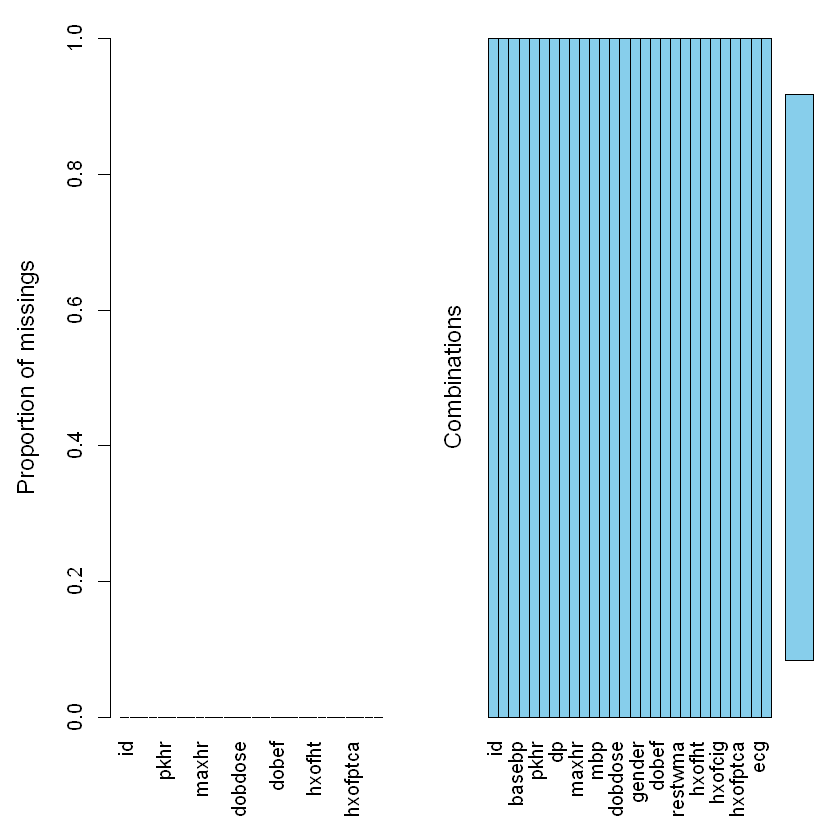

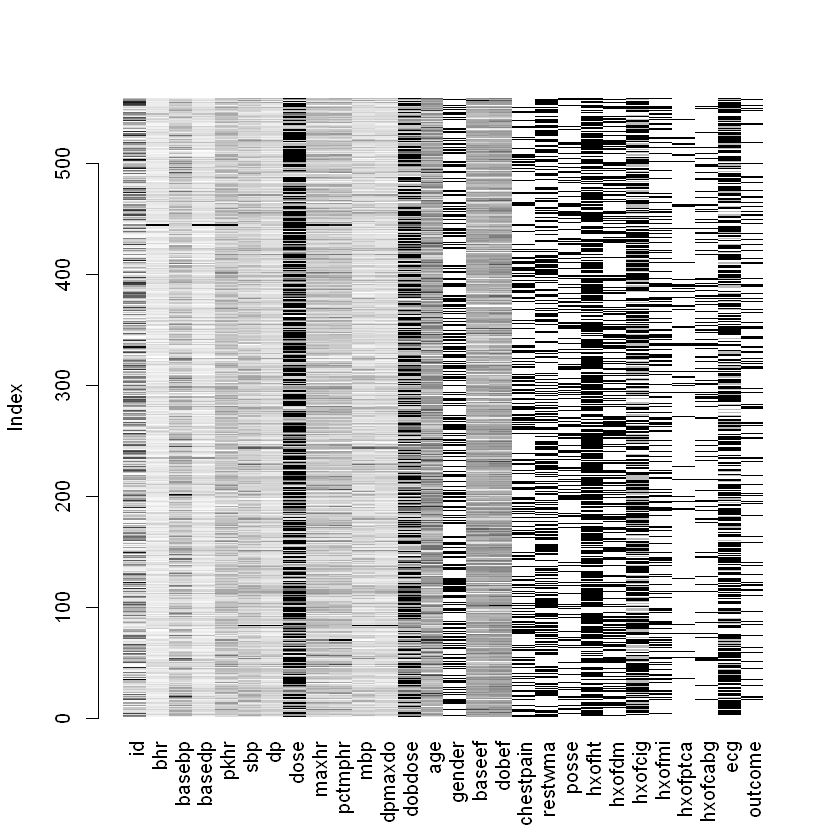

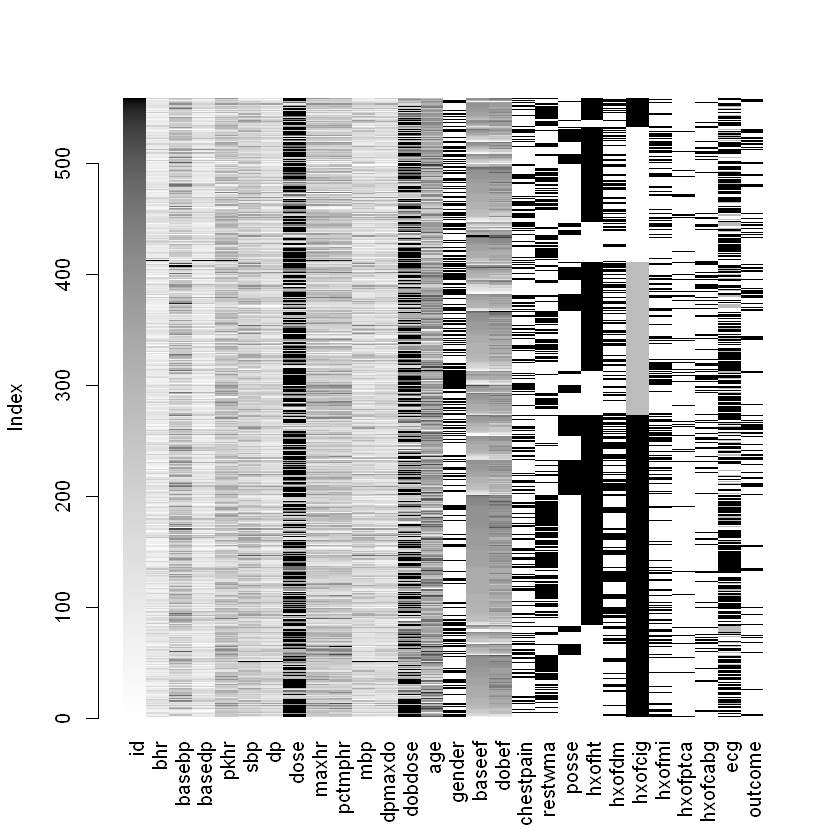

In [6]:
# check for missing values
VIM::aggr(stress_echo)

set.seed(123)
stress_echo %>% slice_sample(n = nrow(.)) %>% matrixplot()
stress_echo %>% matrixplot()

In [7]:
# check other data quality using Skimr, including completeness
stress_echo %>% skim()

-- Data Summary ------------------------
                           Values    
Name                       Piped data
Number of rows             558       
Number of columns          28        
_______________________              
Column type frequency:               
  factor                   11        
  numeric                  17        
________________________             
Group variables            None      

-- Variable type: factor -------------------------------------------------------
# A tibble: 11 x 6
   skim_variable n_missing complete_rate ordered n_unique
 * <chr>             <int>         <dbl> <lgl>      <int>
 1 gender                0             1 FALSE          2
 2 chestpain             0             1 FALSE          2
 3 restwma               0             1 FALSE          2
 4 posse                 0             1 FALSE          2
 5 hxofht                0             1 FALSE          2
 6 hxofdm                0             1 FALSE          2
 7 hxofcig    

In [8]:
# check for duplicates
stress_echo[duplicated(stress_echo), ]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


id,bhr,basebp,basedp,pkhr,sbp,dp,dose,maxhr,pctmphr,⋯,restwma,posse,hxofht,hxofdm,hxofcig,hxofmi,hxofptca,hxofcabg,ecg,outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>


In [38]:
# furthuer checking for outliers
stress_echo_no_out <- stress_echo[,-28] # %>% select(id:dobef, -gender)
stress_echo_no_out[] <- lapply(stress_echo[,-28], function(x){
  if(is.factor(x)){
     x = x
  }else{
    x[x %in% boxplot.stats(x)$out] = mean(x) # replace outliers with the mean to keep the data cases and the same distribution
  }
  x
})

stress_echo_no_out["outcome"] <- stress_echo[,28]
stress_echo <- stress_echo_no_out
# stress_echo

# Descriptive analysis, and further interpreting data

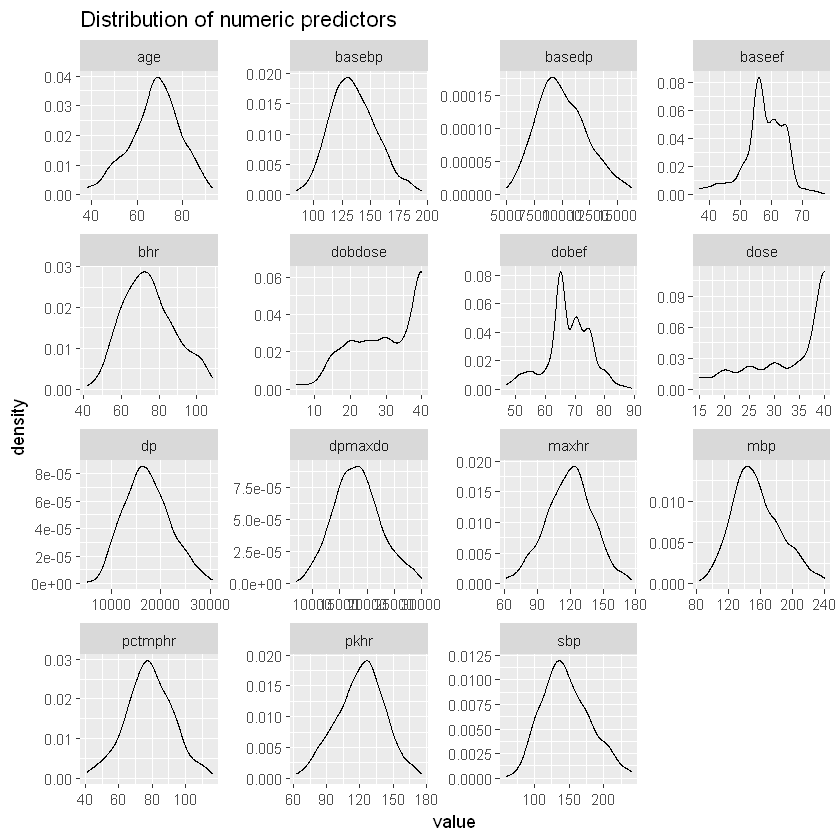

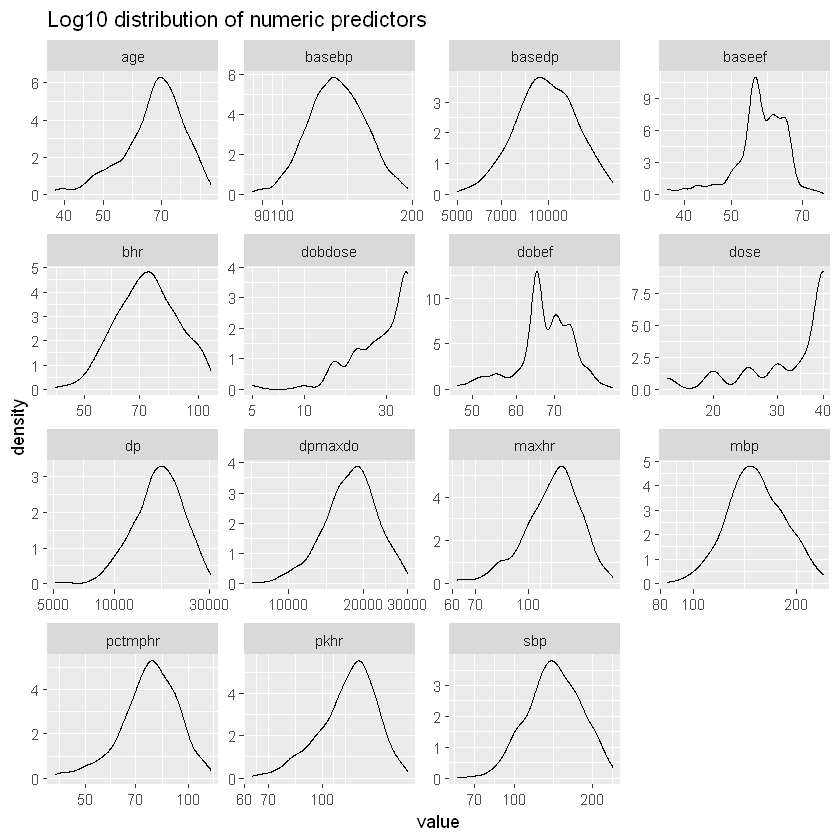

In [10]:
# distributions of the numeric predictors
fig_numeric_dist <- stress_echo %>% 
  select(bhr:dobef, -gender) %>%  # only numerical variables
  pivot_longer(everything(), names_to = "var", values_to = "value") %>%
  ggplot(aes(x = value)) + geom_density() + 
  facet_wrap(vars(var), scales = "free")
fig_numeric_dist + ggtitle("Distribution of numeric predictors")
fig_numeric_dist + scale_x_log10() + ggtitle("Log10 distribution of numeric predictors")

# log 10 distributions look a bit better, making some of the distributions less skewed

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



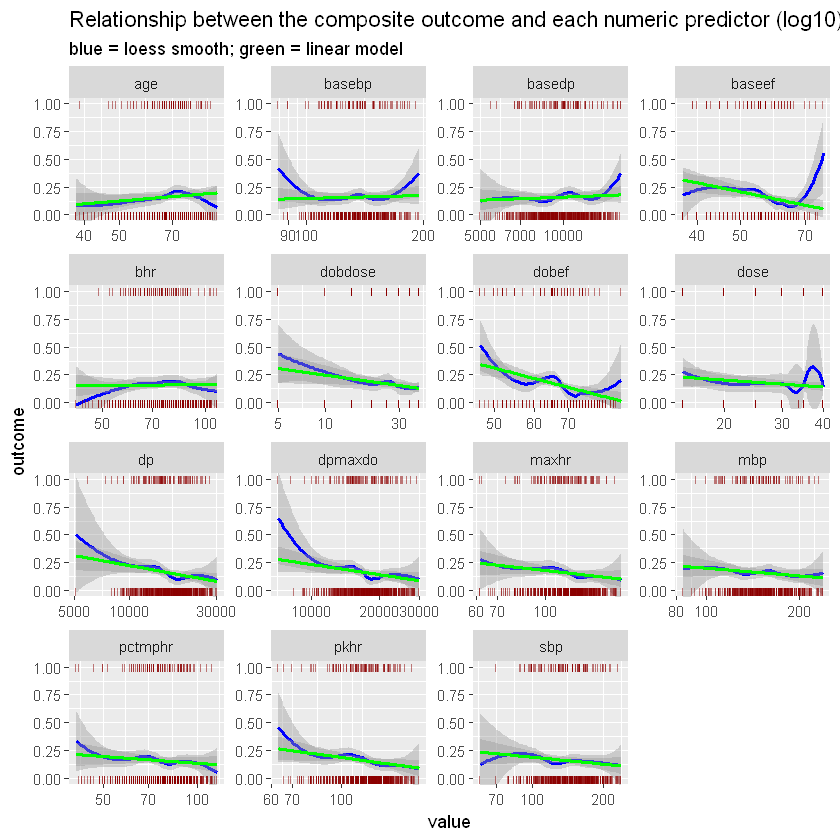

In [11]:
# relationships of numeric predictors to the composite outcome 
fig_numeric <- stress_echo %>% 
  select(outcome, bhr:dobef, -gender) %>%
  # pivot the data so that it has one row per pt per lab value
  pivot_longer(cols = bhr:dobef,
    names_to = "var_name", 
    values_to = "value") %>%
  ggplot(aes(x = value, y = outcome)) + 
  # blue => default loess smoother
  geom_smooth(colour = "blue") + 
  # green => simple straight line smoother "linear model"
  geom_smooth(method = "lm", colour = "green") +
  geom_point(shape = "|", alpha = 0.5, colour = "darkred") +
  facet_wrap(vars(var_name), scales = "free") +
  coord_cartesian(ylim = c(0, 1))

fig_numeric + scale_x_log10() + 
  ggtitle("Relationship between the composite outcome and each numeric predictor (log10)",
    sub = "blue = loess smooth; green = linear model")

`geom_smooth()` using formula 'y ~ x'



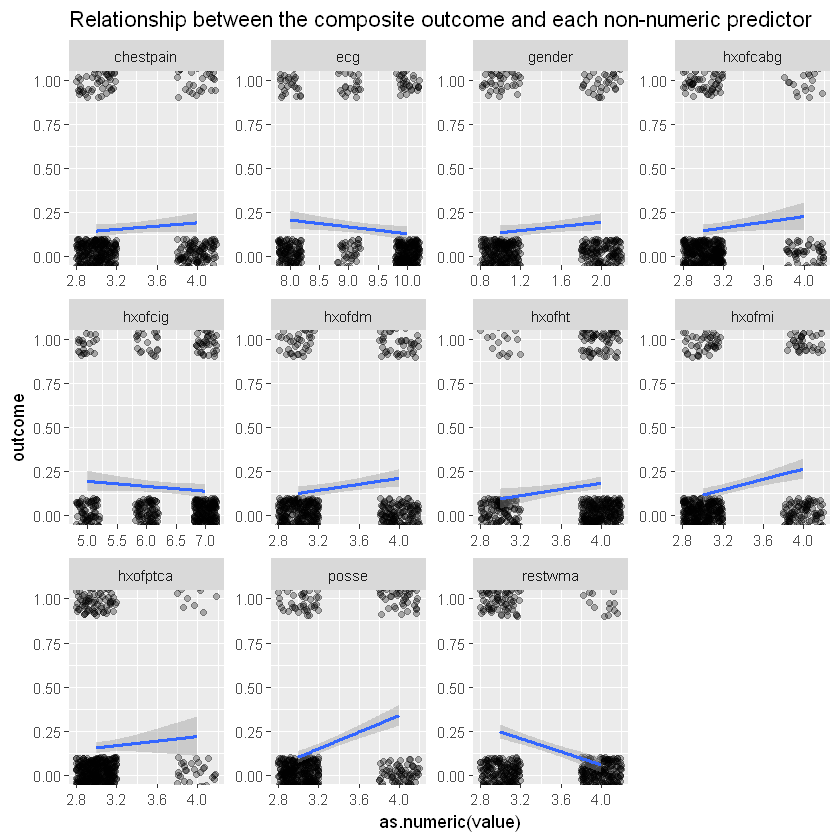

In [12]:
# relationships of non-numeric predictors to the composite outcome 
fig_non_numeric <- stress_echo %>% 
  select(outcome, gender, chestpain, restwma, posse, hxofht, hxofdm, hxofcig, hxofmi, hxofptca, hxofcabg, ecg) %>%
  pivot_longer(cols = gender:ecg,
    names_to = "var_name", 
    values_to = "value") %>%
  ggplot(aes(x = as.numeric(value), y = outcome)) +
  geom_jitter(width = 0.2, height = 0.1, alpha = 0.3) + 
  geom_smooth(method = "lm") + 
  facet_wrap(vars(var_name), scales = "free") +
  coord_cartesian(ylim = c(0, 1))

fig_non_numeric + 
  ggtitle("Relationship between the composite outcome and each non-numeric predictor")

# for ecg, the x axis has the following ordered labels: equivocal, MI, normal
# for hxofcig, the x axis has heavy, moderate, non-smoker
# for gender, the x axis has female, male
# for the rest, the x axis has 0, 1

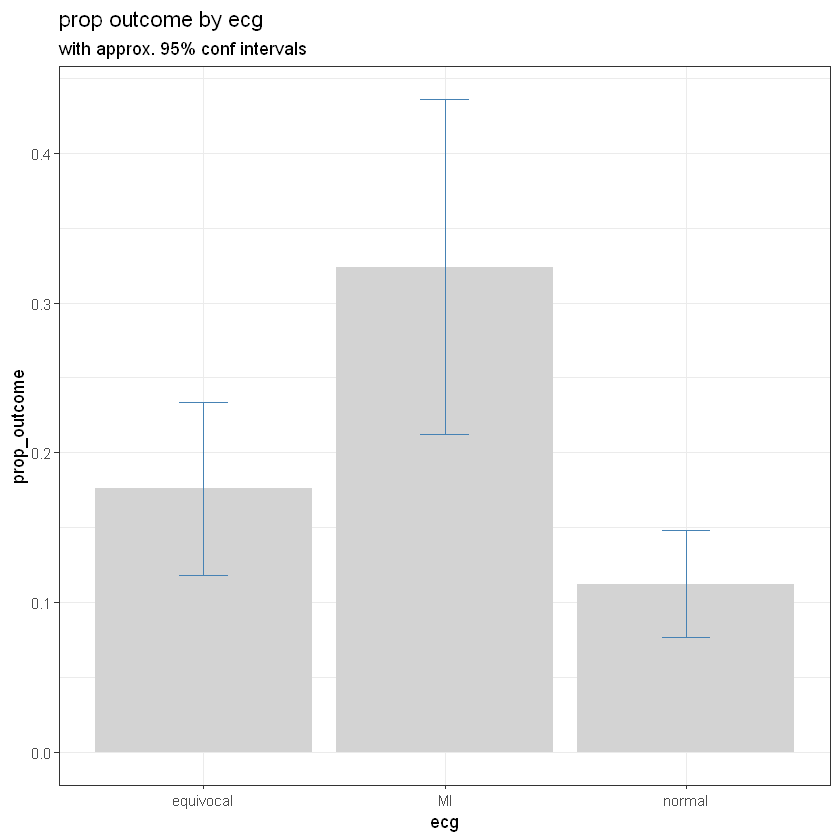

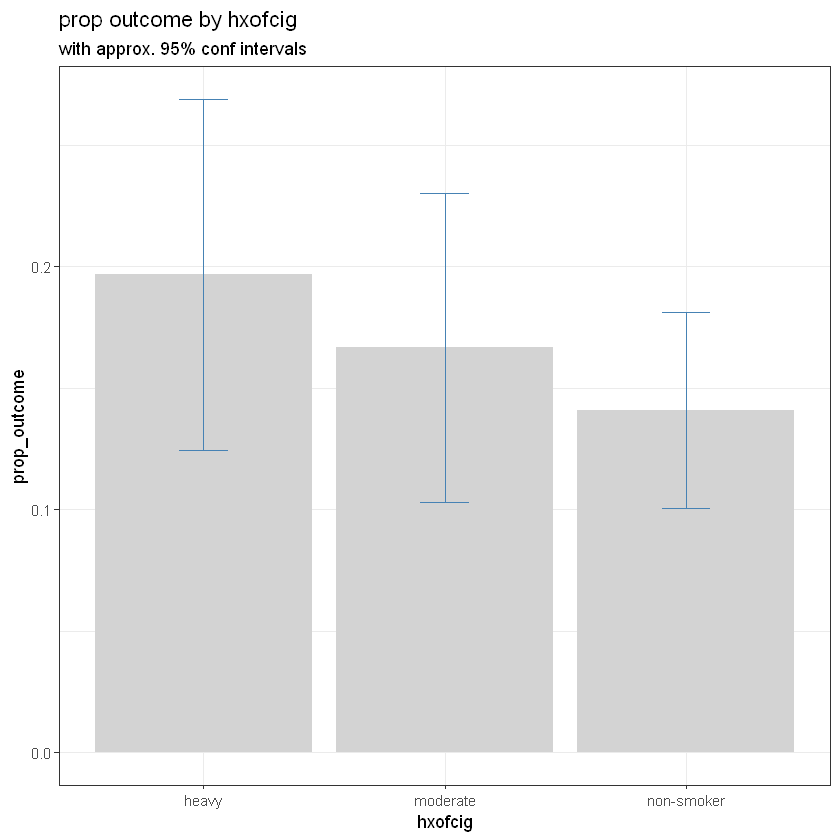

In [13]:
# check for factor variables with multiple levels
summary <- stress_echo %>% group_by(ecg) %>% 
  summarize(prop_outcome = mean(outcome),
    se_hep = sd(outcome)/sqrt(n()),
    low = prop_outcome - 2*se_hep, 
    high = prop_outcome + 2*se_hep, 
    .groups = "drop") 
summary %>%
  ggplot(aes(x = ecg, y = prop_outcome)) + 
  geom_bar(stat = "identity", fill = "lightgray") +
  geom_errorbar(aes(ymin = low, ymax = high), width = 0.2, colour = "steelblue") +
  theme_bw() +
  ggtitle("prop outcome by ecg", subtitle = "with approx. 95% conf intervals")

summary <- stress_echo %>% group_by(hxofcig) %>% 
  summarize(prop_outcome = mean(outcome),
    se_hep = sd(outcome)/sqrt(n()),
    low = prop_outcome - 2*se_hep, 
    high = prop_outcome + 2*se_hep, 
    .groups = "drop") 
summary %>%
  ggplot(aes(x = hxofcig, y = prop_outcome)) + 
  geom_bar(stat = "identity", fill = "lightgray") +
  geom_errorbar(aes(ymin = low, ymax = high), width = 0.2, colour = "steelblue") +
  theme_bw() +
  ggtitle("prop outcome by hxofcig", subtitle = "with approx. 95% conf intervals")


# Model building

In [14]:
# Model building
fit_ads_int <- glm(outcome ~ 1, family = binomial, data = stress_echo)
fit_forward <- step(fit_ads_int,   # start with the smaller model
  scope = list(lower = . ~ 1, 
    upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               ), 
  test = "Chisq", direction = "forward", trace=0)
summary(fit_forward)


Call:
glm(formula = outcome ~ restwma + posse + hxofht + hxofmi + ecg + 
    log10(pkhr) + hxofdm + log10(dobdose) + log10(maxhr), family = binomial, 
    data = stress_echo)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4829  -0.5949  -0.3512  -0.2160   2.8997  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)      5.6666     3.4932   1.622 0.104768    
restwma1        -1.0596     0.3387  -3.128 0.001759 ** 
posse1           0.9869     0.2779   3.551 0.000384 ***
hxofht1          0.6130     0.3269   1.875 0.060790 .  
hxofmi1          0.6668     0.2706   2.464 0.013740 *  
ecgMI            0.7153     0.3534   2.024 0.042953 *  
ecgnormal       -0.1701     0.2942  -0.578 0.563145    
log10(pkhr)    -11.5194     4.8702  -2.365 0.018015 *  
hxofdm1          0.4924     0.2623   1.877 0.060530 .  
log10(dobdose)  -1.3062     0.7116  -1.836 0.066424 .  
log10(maxhr)     8.4384     4.9878   1.692 0.090682 .  
---
Signif. codes:  0 '

In [15]:
fit_ads_big <- glm(outcome ~ 
               log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               , family = binomial, data = stress_echo)
fit_backward <- step(fit_ads_big,   # start with the big model
  scope = list(lower = . ~ 1, 
    upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               ), 
  test = "Chisq", direction = "backward", trace=0)
summary(fit_backward)


Call:
glm(formula = outcome ~ log10(basebp) + log10(basedp) + log10(pkhr) + 
    log10(pctmphr) + restwma + posse + hxofht + hxofdm + hxofmi + 
    ecg, family = binomial, data = stress_echo)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5229  -0.5942  -0.3604  -0.2055   2.7620  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)      4.7233     6.1274   0.771 0.440802    
log10(basebp)   -4.6833     2.5462  -1.839 0.065861 .  
log10(basedp)    3.3272     1.7904   1.858 0.063119 .  
log10(pkhr)     -9.2144     3.2464  -2.838 0.004535 ** 
log10(pctmphr)   4.3935     3.0716   1.430 0.152612    
restwma1        -1.0133     0.3376  -3.002 0.002685 ** 
posse1           1.0677     0.2822   3.784 0.000155 ***
hxofht1          0.6424     0.3315   1.938 0.052675 .  
hxofdm1          0.5665     0.2669   2.123 0.033794 *  
hxofmi1          0.6449     0.2716   2.374 0.017583 *  
ecgMI            0.7580     0.3554   2.133 0.032937 *  
ecgnor

In [16]:
fit_both_start_small <- step(fit_ads_int,   # small model
  scope = list(lower = . ~ 1, 
    upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               ), 
  test = "Chisq", direction = "both", trace=0)

fit_both_start_big <- 
  step(fit_ads_big,   # big model
    scope = list(lower = . ~ 1, 
      upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               ), 
    test = "Chisq", direction = "both", trace=0)

In [17]:
summary(fit_both_start_small)
summary(fit_both_start_big)


Call:
glm(formula = outcome ~ restwma + posse + hxofht + hxofmi + ecg + 
    log10(pkhr) + hxofdm + log10(dobdose) + log10(maxhr), family = binomial, 
    data = stress_echo)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4829  -0.5949  -0.3512  -0.2160   2.8997  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)      5.6666     3.4932   1.622 0.104768    
restwma1        -1.0596     0.3387  -3.128 0.001759 ** 
posse1           0.9869     0.2779   3.551 0.000384 ***
hxofht1          0.6130     0.3269   1.875 0.060790 .  
hxofmi1          0.6668     0.2706   2.464 0.013740 *  
ecgMI            0.7153     0.3534   2.024 0.042953 *  
ecgnormal       -0.1701     0.2942  -0.578 0.563145    
log10(pkhr)    -11.5194     4.8702  -2.365 0.018015 *  
hxofdm1          0.4924     0.2623   1.877 0.060530 .  
log10(dobdose)  -1.3062     0.7116  -1.836 0.066424 .  
log10(maxhr)     8.4384     4.9878   1.692 0.090682 .  
---
Signif. codes:  0 '


Call:
glm(formula = outcome ~ log10(basebp) + log10(basedp) + log10(pkhr) + 
    log10(pctmphr) + restwma + posse + hxofht + hxofdm + hxofmi + 
    ecg, family = binomial, data = stress_echo)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5229  -0.5942  -0.3604  -0.2055   2.7620  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)      4.7233     6.1274   0.771 0.440802    
log10(basebp)   -4.6833     2.5462  -1.839 0.065861 .  
log10(basedp)    3.3272     1.7904   1.858 0.063119 .  
log10(pkhr)     -9.2144     3.2464  -2.838 0.004535 ** 
log10(pctmphr)   4.3935     3.0716   1.430 0.152612    
restwma1        -1.0133     0.3376  -3.002 0.002685 ** 
posse1           1.0677     0.2822   3.784 0.000155 ***
hxofht1          0.6424     0.3315   1.938 0.052675 .  
hxofdm1          0.5665     0.2669   2.123 0.033794 *  
hxofmi1          0.6449     0.2716   2.374 0.017583 *  
ecgMI            0.7580     0.3554   2.133 0.032937 *  
ecgnor

## ROC and AUC for comparison

In [18]:
# evaluation using ROC an AUC
fit_both_start_small_aug <- fit_both_start_small %>% 
  augment(type.predict = "response") %>%  
  rename(pred_prob = .fitted)

fit_both_start_big_aug <- fit_both_start_big %>% 
  augment(type.predict = "response") %>%  
  rename(pred_prob = .fitted)

In [19]:
plot_roc_both_start_small <- fit_both_start_small_aug %>% 
  ggplot(aes(m = pred_prob, d = outcome)) + 
  geom_roc(labels = FALSE) + 
  coord_equal() +
  ggtitle("ROC, both directions started with small model")
auc_fit_both_start_small <- calc_auc(plot_roc_both_start_small) %>% pull(AUC) %>% round(3)

plot_roc_both_start_big <- fit_both_start_big_aug %>% 
  ggplot(aes(m = pred_prob, d = outcome)) + 
  geom_roc(labels = FALSE) + 
  coord_equal() +
  ggtitle("ROC, both directions started with big model")
auc_fit_both_start_big <- calc_auc(plot_roc_both_start_big) %>% pull(AUC) %>% round(3)


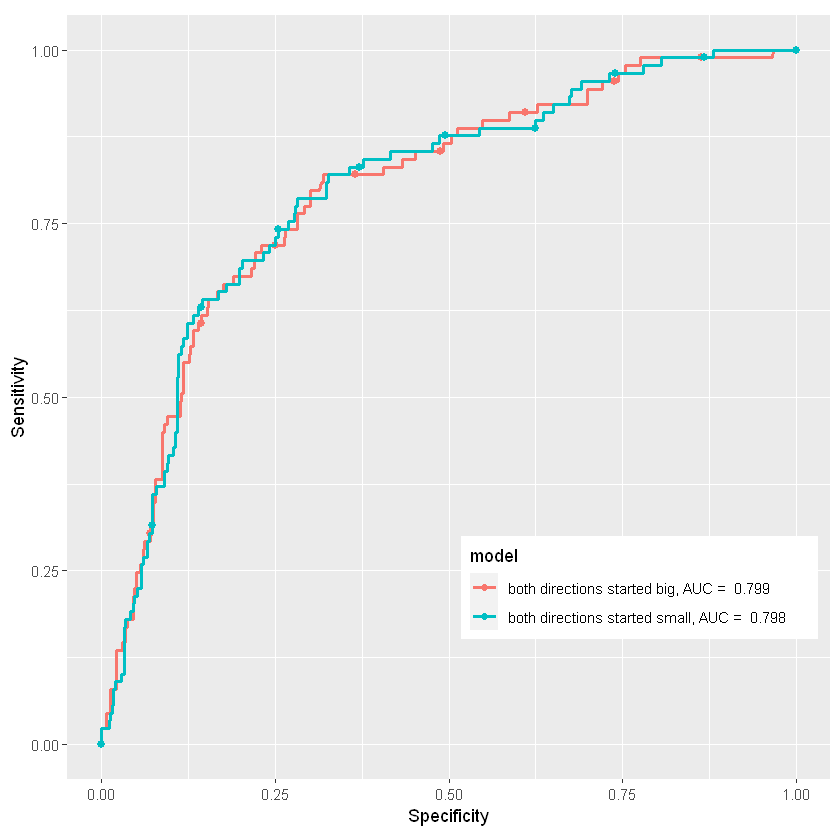

In [20]:
fit_combined_aug <- bind_rows(fit_both_start_small_aug, fit_both_start_big_aug, .id = "model") %>%
  mutate(model = if_else(model == 1, 
    # if model is 1, then it's bw elim
    paste("both directions started big, AUC = ", auc_fit_both_start_big),
    # otherwise it's ast only
    paste("both directions started small, AUC = ", auc_fit_both_start_small)))

fit_combined_aug %>%
  ggplot(aes(m = pred_prob, d = outcome, colour = model)) + 
  geom_roc(labels = FALSE) +
  coord_equal() +
  theme(legend.position = c(0.75, 0.25)) +
  xlab("Specificity") + ylab("Sensitivity")


# Overfitting?

In [21]:
# check for overfitting
set.seed(42)
n_obs <- 558

training_index <- sample(1:n_obs, siz = n_obs*0.8)
glimpse(training_index)

# build training and test sets
stress_echo_train <- stress_echo %>% slice(training_index)
stress_echo_test <- stress_echo %>% slice(-training_index)
nrow(stress_echo_train); nrow(stress_echo_test)

 int [1:446] 321 153 74 228 146 49 128 303 24 356 ...


[1] 446

[1] 112


Call:
glm(formula = outcome ~ restwma + posse + hxofmi + log10(pkhr) + 
    log10(maxhr) + log10(dobdose) + ecg + hxofht + log10(dpmaxdo) + 
    hxofdm, family = binomial, data = stress_echo_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5515  -0.6100  -0.3498  -0.2003   2.9600  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)     12.5050     6.1647   2.028  0.04251 * 
restwma1        -1.1884     0.3998  -2.973  0.00295 **
posse1           0.9716     0.3167   3.068  0.00215 **
hxofmi1          0.6546     0.3059   2.140  0.03237 * 
log10(pkhr)    -16.6295     5.5643  -2.989  0.00280 **
log10(maxhr)    16.2655     6.0557   2.686  0.00723 **
log10(dobdose)  -1.4385     0.8416  -1.709  0.08740 . 
ecgMI            0.7125     0.3916   1.819  0.06888 . 
ecgnormal       -0.2491     0.3373  -0.739  0.46011   
hxofht1          0.5996     0.3653   1.642  0.10066   
log10(dpmaxdo)  -2.8688     1.8571  -1.545  0.12240   
hxofdm1     

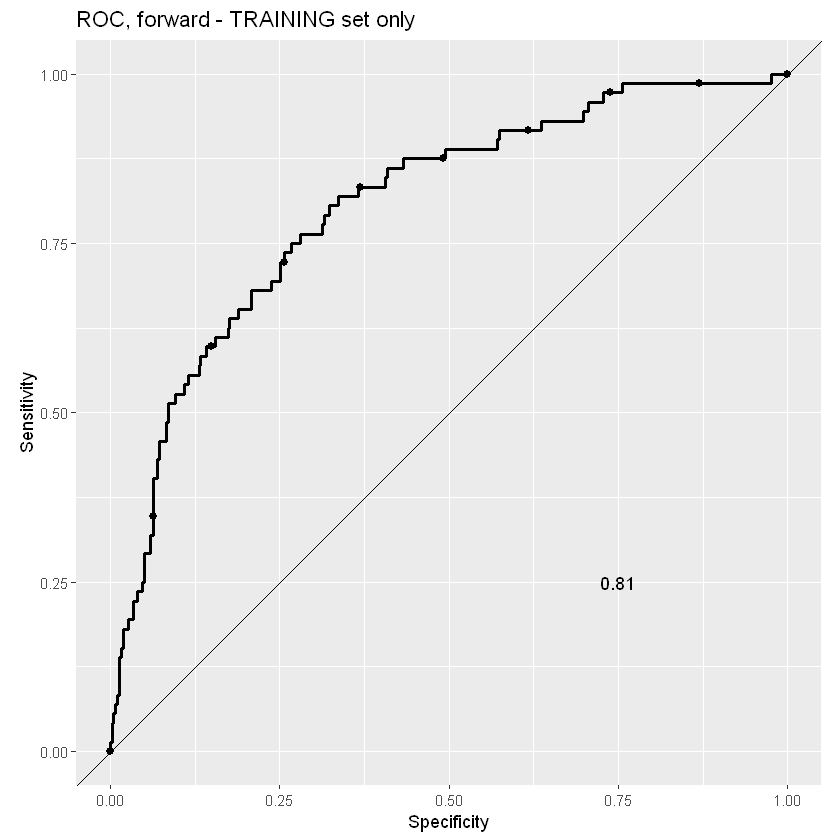

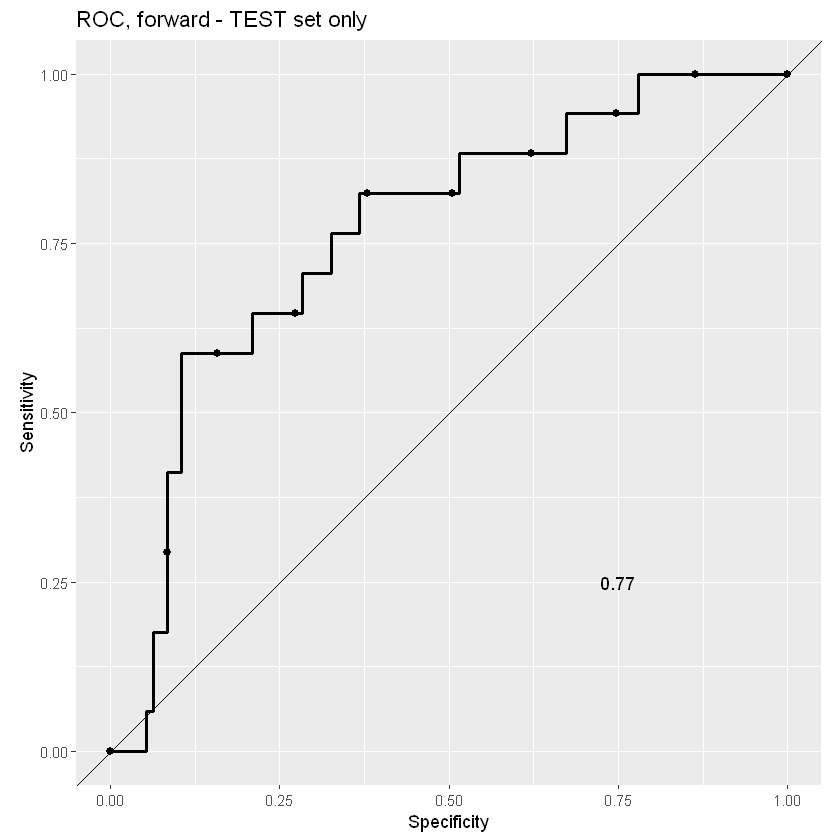

In [22]:
# build the models again and check for overfitting
fit_ads_int_overfit <- glm(outcome ~ 1, family = binomial, data = stress_echo_train)
fit_forward_overfit <- step(fit_ads_int_overfit,   # start with the smaller model
  scope = list(lower = . ~ 1, 
    upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               ), 
  test = "Chisq", direction = "forward", trace=0)
summary(fit_forward_overfit)

plot_forward_train <- fit_forward_overfit %>%  
  ## augment the *training* set with predictions
  augment(type.predict = "response") %>% 
  ggplot(aes(m = .fitted, d = outcome)) + geom_roc(labels = FALSE) 

plot_forward_train + coord_equal() + 
  geom_abline(intercept = 0, slope = 1) +
  xlab("Specificity") + ylab("Sensitivity") +
  ggtitle("ROC, forward - TRAINING set only") +
  annotate("text", x = 0.75, y = 0.25, 
    label = round(calc_auc(plot_forward_train) %>% pull(AUC), 2))

plot_forward_test <- fit_forward_overfit %>%  
  ## augment the *test* set with predictions
  augment(type.predict = "response", newdata = stress_echo_test) %>% 
  ggplot(aes(m = .fitted, d = outcome)) + geom_roc(labels = FALSE) 

plot_forward_test + coord_equal() + 
  geom_abline(intercept = 0, slope = 1) +
  xlab("Specificity") + ylab("Sensitivity") +
  ggtitle("ROC, forward - TEST set only") +
  annotate("text", x = 0.75, y = 0.25, 
    label = round(calc_auc(plot_forward_test) %>% pull(AUC), 2))


Call:
glm(formula = outcome ~ log10(pkhr) + log10(maxhr) + log10(mbp) + 
    log10(dobdose) + restwma + posse + hxofht + hxofdm + hxofmi + 
    ecg, family = binomial, data = stress_echo_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5528  -0.5913  -0.3482  -0.2011   2.9557  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)     12.2597     6.0138   2.039  0.04149 * 
log10(pkhr)    -16.4748     5.5453  -2.971  0.00297 **
log10(maxhr)    13.3874     5.6935   2.351  0.01871 * 
log10(mbp)      -2.9206     1.8676  -1.564  0.11787   
log10(dobdose)  -1.4057     0.8425  -1.668  0.09523 . 
restwma1        -1.1771     0.4005  -2.939  0.00329 **
posse1           0.9831     0.3176   3.095  0.00197 **
hxofht1          0.6170     0.3664   1.684  0.09221 . 
hxofdm1          0.4569     0.2981   1.533  0.12534   
hxofmi1          0.6509     0.3067   2.122  0.03382 * 
ecgMI            0.6930     0.3916   1.770  0.07675 . 
ecgnormal       

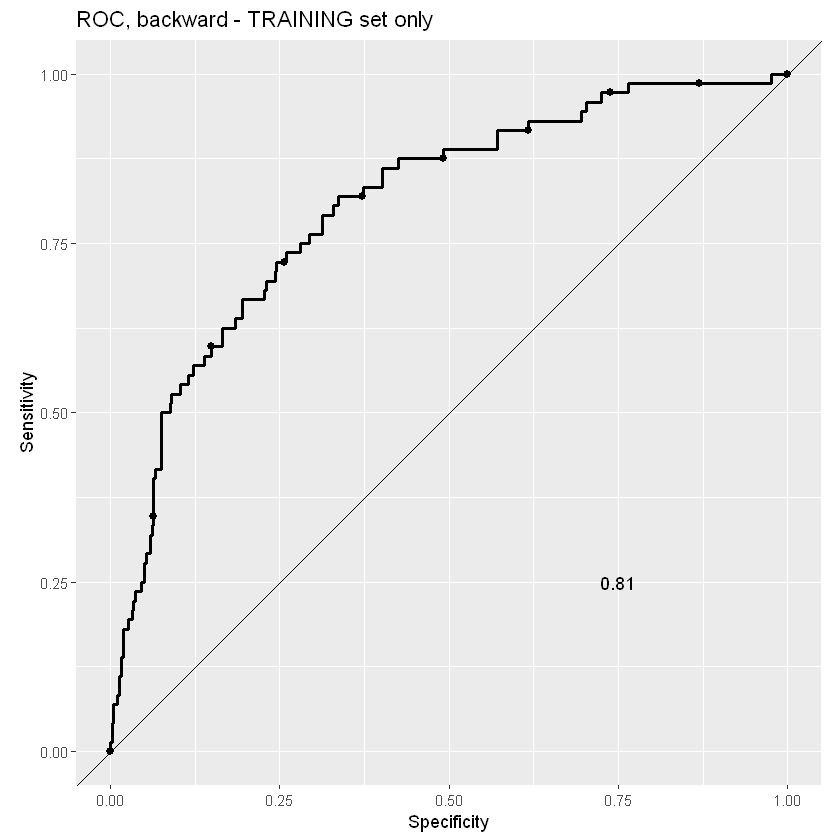

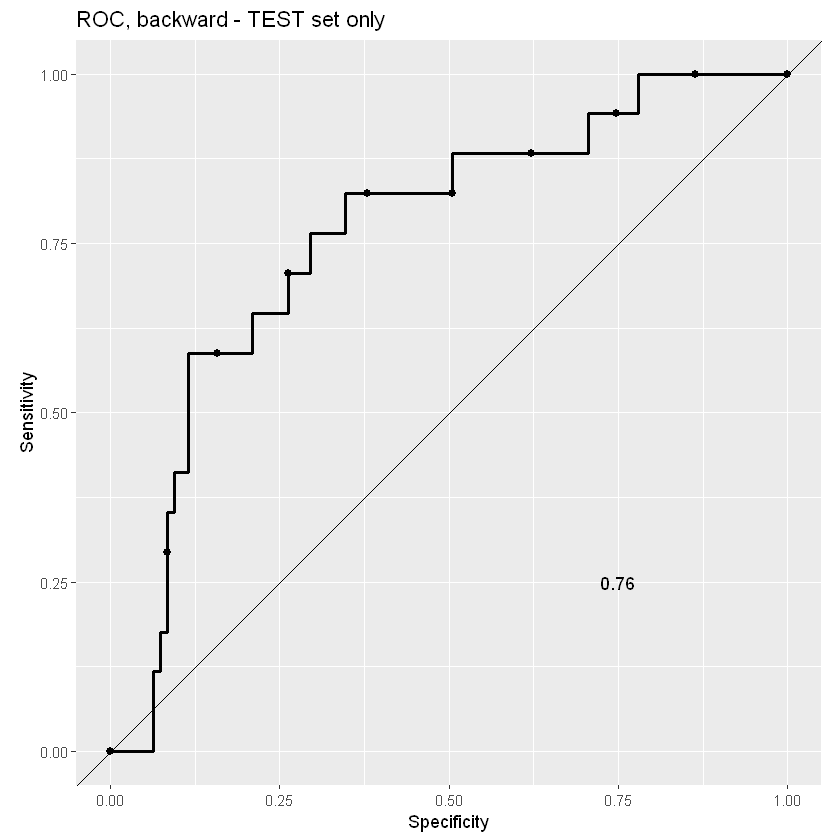

In [23]:
fit_ads_big_overfit <- glm(outcome ~ 
               log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               , family = binomial, data = stress_echo_train)
fit_backward_overfit <- step(fit_ads_big_overfit,   # start with the big model
  scope = list(lower = . ~ 1, 
    upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               ), 
  test = "Chisq", direction = "backward", trace=0)
summary(fit_backward_overfit)

plot_backward_train <- fit_backward_overfit %>%  
  ## augment the *training* set with predictions
  augment(type.predict = "response") %>% 
  ggplot(aes(m = .fitted, d = outcome)) + geom_roc(labels = FALSE) 

plot_backward_train + coord_equal() + 
  geom_abline(intercept = 0, slope = 1) +
  xlab("Specificity") + ylab("Sensitivity") +
  ggtitle("ROC, backward - TRAINING set only") +
  annotate("text", x = 0.75, y = 0.25, 
    label = round(calc_auc(plot_backward_train) %>% pull(AUC), 2))

plot_backward_test <- fit_backward_overfit %>%  
  ## augment the *test* set with predictions
  augment(type.predict = "response", newdata = stress_echo_test) %>% 
  ggplot(aes(m = .fitted, d = outcome)) + geom_roc(labels = FALSE) 

plot_backward_test + coord_equal() + 
  geom_abline(intercept = 0, slope = 1) +
  xlab("Specificity") + ylab("Sensitivity") +
  ggtitle("ROC, backward - TEST set only") +
  annotate("text", x = 0.75, y = 0.25, 
    label = round(calc_auc(plot_backward_test) %>% pull(AUC), 2))


Call:
glm(formula = outcome ~ restwma + posse + hxofmi + log10(pkhr) + 
    log10(maxhr) + log10(dobdose) + ecg + hxofht + log10(dpmaxdo) + 
    hxofdm, family = binomial, data = stress_echo_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5515  -0.6100  -0.3498  -0.2003   2.9600  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)     12.5050     6.1647   2.028  0.04251 * 
restwma1        -1.1884     0.3998  -2.973  0.00295 **
posse1           0.9716     0.3167   3.068  0.00215 **
hxofmi1          0.6546     0.3059   2.140  0.03237 * 
log10(pkhr)    -16.6295     5.5643  -2.989  0.00280 **
log10(maxhr)    16.2655     6.0557   2.686  0.00723 **
log10(dobdose)  -1.4385     0.8416  -1.709  0.08740 . 
ecgMI            0.7125     0.3916   1.819  0.06888 . 
ecgnormal       -0.2491     0.3373  -0.739  0.46011   
hxofht1          0.5996     0.3653   1.642  0.10066   
log10(dpmaxdo)  -2.8688     1.8571  -1.545  0.12240   
hxofdm1     

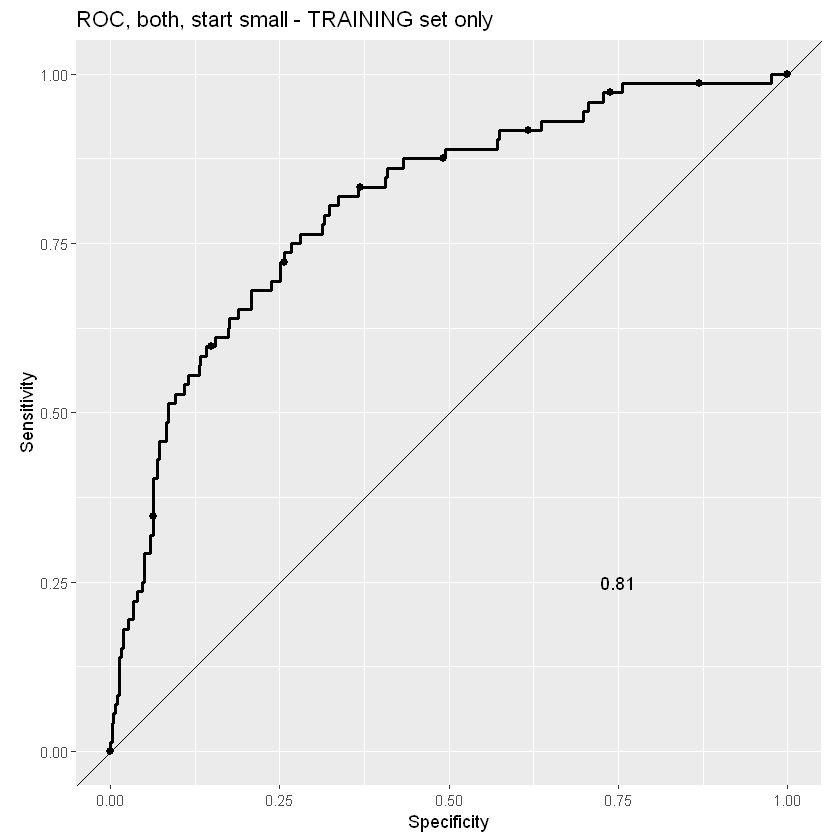

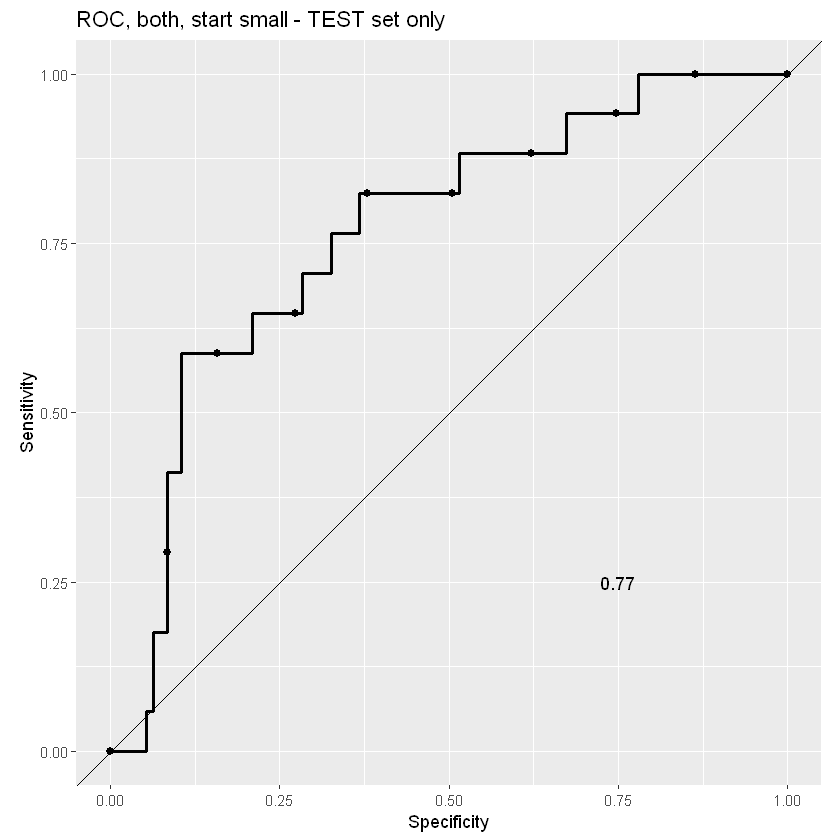

In [24]:
fit_both_start_small_overfit <- step(fit_ads_int_overfit,   # start with the small model
  scope = list(lower = . ~ 1, 
    upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               ), 
  test = "Chisq", direction = "both", trace=0)
summary(fit_both_start_small_overfit)

plot_both_start_small_train <- fit_both_start_small_overfit %>%  
  ## augment the *training* set with predictions
  augment(type.predict = "response") %>% 
  ggplot(aes(m = .fitted, d = outcome)) + geom_roc(labels = FALSE) 

plot_both_start_small_train + coord_equal() + 
  geom_abline(intercept = 0, slope = 1) +
  xlab("Specificity") + ylab("Sensitivity") +
  ggtitle("ROC, both, start small - TRAINING set only") +
  annotate("text", x = 0.75, y = 0.25, 
    label = round(calc_auc(plot_both_start_small_train) %>% pull(AUC), 2))

plot_both_start_small_test <- fit_both_start_small_overfit %>%  
  ## augment the *test* set with predictions
  augment(type.predict = "response", newdata = stress_echo_test) %>% 
  ggplot(aes(m = .fitted, d = outcome)) + geom_roc(labels = FALSE) 

plot_both_start_small_test + coord_equal() + 
  geom_abline(intercept = 0, slope = 1) +
  xlab("Specificity") + ylab("Sensitivity") +
  ggtitle("ROC, both, start small - TEST set only") +
  annotate("text", x = 0.75, y = 0.25, 
    label = round(calc_auc(plot_both_start_small_test) %>% pull(AUC), 2))


Call:
glm(formula = outcome ~ log10(pkhr) + log10(maxhr) + log10(mbp) + 
    log10(dobdose) + restwma + posse + hxofht + hxofdm + hxofmi + 
    ecg, family = binomial, data = stress_echo_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5528  -0.5913  -0.3482  -0.2011   2.9557  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)     12.2597     6.0138   2.039  0.04149 * 
log10(pkhr)    -16.4748     5.5453  -2.971  0.00297 **
log10(maxhr)    13.3874     5.6935   2.351  0.01871 * 
log10(mbp)      -2.9206     1.8676  -1.564  0.11787   
log10(dobdose)  -1.4057     0.8425  -1.668  0.09523 . 
restwma1        -1.1771     0.4005  -2.939  0.00329 **
posse1           0.9831     0.3176   3.095  0.00197 **
hxofht1          0.6170     0.3664   1.684  0.09221 . 
hxofdm1          0.4569     0.2981   1.533  0.12534   
hxofmi1          0.6509     0.3067   2.122  0.03382 * 
ecgMI            0.6930     0.3916   1.770  0.07675 . 
ecgnormal       

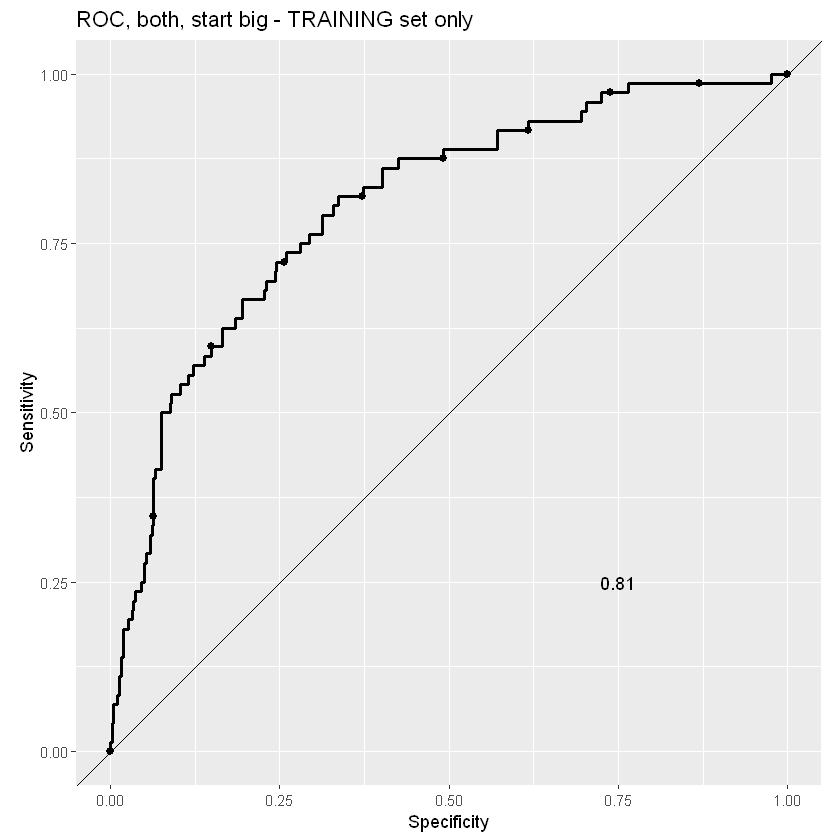

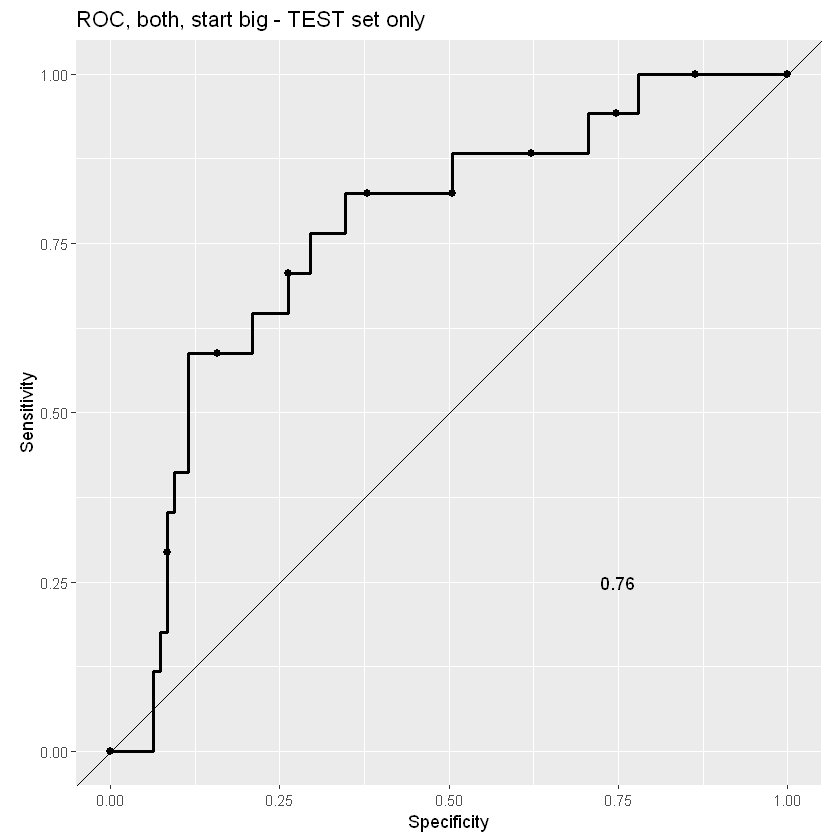

In [25]:
fit_both_start_big_overfit <- step(fit_ads_big_overfit,   # start with the big model
  scope = list(lower = . ~ 1, 
    upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               ), 
  test = "Chisq", direction = "both", trace=0)
summary(fit_both_start_big_overfit)

plot_both_start_big_train <- fit_both_start_big_overfit %>%  
  ## augment the *training* set with predictions
  augment(type.predict = "response") %>% 
  ggplot(aes(m = .fitted, d = outcome)) + geom_roc(labels = FALSE) 

plot_both_start_big_train + coord_equal() + 
  geom_abline(intercept = 0, slope = 1) +
  xlab("Specificity") + ylab("Sensitivity") +
  ggtitle("ROC, both, start big - TRAINING set only") +
  annotate("text", x = 0.75, y = 0.25, 
    label = round(calc_auc(plot_both_start_big_train) %>% pull(AUC), 2))

plot_both_start_big_test <- fit_both_start_big_overfit %>%  
  ## augment the *test* set with predictions
  augment(type.predict = "response", newdata = stress_echo_test) %>% 
  ggplot(aes(m = .fitted, d = outcome)) + geom_roc(labels = FALSE) 

plot_both_start_big_test + coord_equal() + 
  geom_abline(intercept = 0, slope = 1) +
  xlab("Specificity") + ylab("Sensitivity") +
  ggtitle("ROC, both, start big - TEST set only") +
  annotate("text", x = 0.75, y = 0.25, 
    label = round(calc_auc(plot_both_start_big_test) %>% pull(AUC), 2))

# Cross-validation

In [26]:
# correct for overfitting by cross-validation

# 5-fold
set.seed(1963)
stress_echo_cv <- crossv_kfold(stress_echo, 5)

In [27]:
fit_cv_fw <- stress_echo_cv %>%
  # train our forward selection models on each training set
  mutate(model_fwd = map(train, 
    ~ step(glm(outcome ~ 1, family = binomial, data = .), 
      scope =  list(lower = . ~ 1, 
                upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
                + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
                ), test = "Chisq", direction = "forward", trace=0))) %>%
  # take those model fits and augment with the predictions ** FOR THE TEST SET
  mutate(model_preds_test = map2(model_fwd, test, ~ augment(.x, newdata = .y)))  %>%
  mutate(model_preds_train = map2(model_fwd, train, ~ augment(.x, newdata = .y)))  %>%
  # take these predicted values (TEST SET!) and get the ROC curves...
  mutate(roc_plot_test = map(model_preds_test, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(roc_plot_train = map(model_preds_train, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  # ... and then calc the AUC
  mutate(auc_value_test = map(roc_plot_test, ~ calc_auc(.)$AUC)) %>%
  mutate(auc_value_train = map(roc_plot_train, ~ calc_auc(.)$AUC)) %>%
  unnest(c(auc_value_test, auc_value_train))

fit_cv_fw %>% select(.id, auc_value_test, auc_value_train)

auc_fit_cv_fw <- fit_cv_fw %>% 
  summarize(mean_auc_test = mean(auc_value_test),
    mean_auc_train = mean(auc_value_train),
    mean_diff_train_test = mean(auc_value_train - auc_value_test))
auc_fit_cv_fw

.id,auc_value_test,auc_value_train
<chr>,<dbl>,<dbl>
1,0.6932654,0.8167933
2,0.7221350,0.8039799
3,0.7839938,0.7915185
4,0.8410513,0.7777037
5,0.6796339,0.7987495


mean_auc_test,mean_auc_train,mean_diff_train_test
<dbl>,<dbl>,<dbl>
0.7440159,0.797749,0.05373311


In [28]:
fit_cv_bw <- stress_echo_cv %>%
  mutate(model_bwd = map(train, 
    ~ step(glm(outcome ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               , family = binomial, data = .), 
      scope =  list(lower = . ~ 1, 
                upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
                + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
                ), test = "Chisq", direction = "backward", trace=0))) %>%
  mutate(model_preds_test = map2(model_bwd, test, ~ augment(.x, newdata = .y)))  %>%
  mutate(model_preds_train = map2(model_bwd, train, ~ augment(.x, newdata = .y)))  %>%
  mutate(roc_plot_test = map(model_preds_test, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(roc_plot_train = map(model_preds_train, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(auc_value_test = map(roc_plot_test, ~ calc_auc(.)$AUC)) %>%
  mutate(auc_value_train = map(roc_plot_train, ~ calc_auc(.)$AUC)) %>%
  unnest(c(auc_value_test, auc_value_train))

fit_cv_bw %>% select(.id, auc_value_test, auc_value_train)

auc_fit_cv_bw <- fit_cv_bw %>% 
  summarize(mean_auc_test = mean(auc_value_test),
    mean_auc_train = mean(auc_value_train),
    mean_diff_train_test = mean(auc_value_train - auc_value_test))
auc_fit_cv_bw

.id,auc_value_test,auc_value_train
<chr>,<dbl>,<dbl>
1,0.6932654,0.8167933
2,0.6917844,0.8100685
3,0.7948718,0.7952347
4,0.8366708,0.7829259
5,0.6538902,0.7985222


mean_auc_test,mean_auc_train,mean_diff_train_test
<dbl>,<dbl>,<dbl>
0.7340965,0.8007089,0.06661239


In [29]:
fit_cv_both_small <- stress_echo_cv %>%
  mutate(model_both = map(train, 
    ~ step(glm(outcome ~ 1, family = binomial, data = .), 
      scope =  list(lower = . ~ 1, 
                upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
                + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
                ), test = "Chisq", direction = "both", trace=0))) %>%
  mutate(model_preds_test = map2(model_both, test, ~ augment(.x, newdata = .y)))  %>%
  mutate(model_preds_train = map2(model_both, train, ~ augment(.x, newdata = .y)))  %>%
  mutate(roc_plot_test = map(model_preds_test, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(roc_plot_train = map(model_preds_train, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(auc_value_test = map(roc_plot_test, ~ calc_auc(.)$AUC)) %>%
  mutate(auc_value_train = map(roc_plot_train, ~ calc_auc(.)$AUC)) %>%
  unnest(c(auc_value_test, auc_value_train))

fit_cv_both_small %>% select(.id, auc_value_test, auc_value_train)

auc_fit_cv_both_small <- fit_cv_both_small %>% 
  summarize(mean_auc_test = mean(auc_value_test),
    mean_auc_train = mean(auc_value_train),
    mean_diff_train_test = mean(auc_value_train - auc_value_test))
auc_fit_cv_both_small

.id,auc_value_test,auc_value_train
<chr>,<dbl>,<dbl>
1,0.6932654,0.8167933
2,0.7221350,0.8039799
3,0.7839938,0.7915185
4,0.8410513,0.7777037
5,0.6796339,0.7987495


mean_auc_test,mean_auc_train,mean_diff_train_test
<dbl>,<dbl>,<dbl>
0.7440159,0.797749,0.05373311


In [30]:
fit_cv_both_big <- stress_echo_cv %>%
  mutate(model_both = map(train, 
    ~ step(glm(outcome ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               , family = binomial, data = .), 
      scope =  list(lower = . ~ 1, 
                upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
                + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
                ), test = "Chisq", direction = "both", trace=0))) %>%
  mutate(model_preds_test = map2(model_both, test, ~ augment(.x, newdata = .y)))  %>%
  mutate(model_preds_train = map2(model_both, train, ~ augment(.x, newdata = .y)))  %>%
  mutate(roc_plot_test = map(model_preds_test, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(roc_plot_train = map(model_preds_train, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(auc_value_test = map(roc_plot_test, ~ calc_auc(.)$AUC)) %>%
  mutate(auc_value_train = map(roc_plot_train, ~ calc_auc(.)$AUC)) %>%
  unnest(c(auc_value_test, auc_value_train))

fit_cv_both_big %>% select(.id, auc_value_test, auc_value_train)

auc_fit_cv_both_big <- fit_cv_both_big %>% 
  summarize(mean_auc_test = mean(auc_value_test),
    mean_auc_train = mean(auc_value_train),
    mean_diff_train_test = mean(auc_value_train - auc_value_test))
auc_fit_cv_both_big

.id,auc_value_test,auc_value_train
<chr>,<dbl>,<dbl>
1,0.6932654,0.8167933
2,0.6917844,0.8100685
3,0.7948718,0.7952347
4,0.8366708,0.7829259
5,0.6538902,0.7985222


mean_auc_test,mean_auc_train,mean_diff_train_test
<dbl>,<dbl>,<dbl>
0.7340965,0.8007089,0.06661239


In [31]:
# 10-fold
stress_echo_10cv <- crossv_kfold(stress_echo, 10)

In [32]:
fit_cv_fw <- stress_echo_10cv %>%
  mutate(model_fwd = map(train, 
    ~ step(glm(outcome ~ 1, family = binomial, data = .), 
      scope =  list(lower = . ~ 1, 
                upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
                + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
                ), test = "Chisq", direction = "forward", trace=0))) %>%
  mutate(model_preds_test = map2(model_fwd, test, ~ augment(.x, newdata = .y)))  %>%
  mutate(model_preds_train = map2(model_fwd, train, ~ augment(.x, newdata = .y)))  %>%
  mutate(roc_plot_test = map(model_preds_test, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(roc_plot_train = map(model_preds_train, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(auc_value_test = map(roc_plot_test, ~ calc_auc(.)$AUC)) %>%
  mutate(auc_value_train = map(roc_plot_train, ~ calc_auc(.)$AUC)) %>%
  unnest(c(auc_value_test, auc_value_train))

fit_cv_fw %>% select(.id, auc_value_test, auc_value_train)

auc_fit_cv_fw <- fit_cv_fw %>% 
  summarize(mean_auc_test = mean(auc_value_test),
    mean_auc_train = mean(auc_value_train),
    mean_diff_train_test = mean(auc_value_train - auc_value_test))
auc_fit_cv_fw

.id,auc_value_test,auc_value_train
<chr>,<dbl>,<dbl>
01,0.7500000,0.7885986
02,0.6739130,0.7996229
03,0.8061466,0.7916321
04,0.6453901,0.8130480
05,0.6725768,0.8017773
06,0.7163121,0.8003406
07,0.7848700,0.7891440
08,0.7848700,0.7902103
09,0.7480620,0.7858667


mean_auc_test,mean_auc_train,mean_diff_train_test
<dbl>,<dbl>,<dbl>
0.7426141,0.7957433,0.05312928


In [33]:
fit_cv_bw <- stress_echo_10cv %>%
  mutate(model_bwd = map(train, 
    ~ step(glm(outcome ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               , family = binomial, data = .), 
      scope =  list(lower = . ~ 1, 
                upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
                + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
                ), test = "Chisq", direction = "backward", trace=0))) %>%
  mutate(model_preds_test = map2(model_bwd, test, ~ augment(.x, newdata = .y)))  %>%
  mutate(model_preds_train = map2(model_bwd, train, ~ augment(.x, newdata = .y)))  %>%
  mutate(roc_plot_test = map(model_preds_test, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(roc_plot_train = map(model_preds_train, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(auc_value_test = map(roc_plot_test, ~ calc_auc(.)$AUC)) %>%
  mutate(auc_value_train = map(roc_plot_train, ~ calc_auc(.)$AUC)) %>%
  unnest(c(auc_value_test, auc_value_train))

fit_cv_bw %>% select(.id, auc_value_test, auc_value_train)

auc_fit_cv_bw <- fit_cv_bw %>% 
  summarize(mean_auc_test = mean(auc_value_test),
    mean_auc_train = mean(auc_value_train),
    mean_diff_train_test = mean(auc_value_train - auc_value_test))
auc_fit_cv_bw

.id,auc_value_test,auc_value_train
<chr>,<dbl>,<dbl>
01,0.7526042,0.7943755
02,0.7173913,0.8050094
03,0.8061466,0.7916321
04,0.6453901,0.8130480
05,0.6725768,0.8017773
06,0.7352246,0.7995409
07,0.7044917,0.7930983
08,0.7588652,0.7834271
09,0.7500000,0.7944942


mean_auc_test,mean_auc_train,mean_diff_train_test
<dbl>,<dbl>,<dbl>
0.7230691,0.7983853,0.07531621


In [34]:
fit_cv_both_small <- stress_echo_10cv %>%
  mutate(model_both = map(train, 
    ~ step(glm(outcome ~ 1, family = binomial, data = .), 
      scope =  list(lower = . ~ 1, 
                upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
                + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
                ), test = "Chisq", direction = "both", trace=0))) %>%
  mutate(model_preds_test = map2(model_both, test, ~ augment(.x, newdata = .y)))  %>%
  mutate(model_preds_train = map2(model_both, train, ~ augment(.x, newdata = .y)))  %>%
  mutate(roc_plot_test = map(model_preds_test, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(roc_plot_train = map(model_preds_train, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(auc_value_test = map(roc_plot_test, ~ calc_auc(.)$AUC)) %>%
  mutate(auc_value_train = map(roc_plot_train, ~ calc_auc(.)$AUC)) %>%
  unnest(c(auc_value_test, auc_value_train))

fit_cv_both_small %>% select(.id, auc_value_test, auc_value_train)

auc_fit_cv_both_small <- fit_cv_both_small %>% 
  summarize(mean_auc_test = mean(auc_value_test),
    mean_auc_train = mean(auc_value_train),
    mean_diff_train_test = mean(auc_value_train - auc_value_test))
auc_fit_cv_both_small

.id,auc_value_test,auc_value_train
<chr>,<dbl>,<dbl>
01,0.7500000,0.7885986
02,0.6739130,0.7996229
03,0.8061466,0.7916321
04,0.6453901,0.8130480
05,0.6725768,0.8017773
06,0.7163121,0.8003406
07,0.7848700,0.7891440
08,0.7848700,0.7902103
09,0.7480620,0.7858667


mean_auc_test,mean_auc_train,mean_diff_train_test
<dbl>,<dbl>,<dbl>
0.7426141,0.7957433,0.05312928


In [35]:
fit_cv_both_big <- stress_echo_10cv %>%
  mutate(model_both = map(train, 
    ~ step(glm(outcome ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
               + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
               , family = binomial, data = .), 
      scope =  list(lower = . ~ 1, 
                upper = . ~ log10(bhr) + log10(basebp) + log10(basedp) + log10(pkhr) + log10(sbp) + log10(dp) + log10(dose) + log10(maxhr) + log10(pctmphr) + log10(mbp) + log10(dpmaxdo) + log10(dobdose)
                + gender + chestpain + restwma + posse + hxofht + hxofdm + hxofcig + hxofmi + hxofptca + hxofcabg + ecg
                ), test = "Chisq", direction = "both", trace=0))) %>%
  mutate(model_preds_test = map2(model_both, test, ~ augment(.x, newdata = .y)))  %>%
  mutate(model_preds_train = map2(model_both, train, ~ augment(.x, newdata = .y)))  %>%
  mutate(roc_plot_test = map(model_preds_test, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(roc_plot_train = map(model_preds_train, 
    ~ ggplot(., aes(m = .fitted, d = outcome)) + geom_roc())) %>%
  mutate(auc_value_test = map(roc_plot_test, ~ calc_auc(.)$AUC)) %>%
  mutate(auc_value_train = map(roc_plot_train, ~ calc_auc(.)$AUC)) %>%
  unnest(c(auc_value_test, auc_value_train))

fit_cv_both_big %>% select(.id, auc_value_test, auc_value_train)

auc_fit_cv_both_big <- fit_cv_both_big %>% 
  summarize(mean_auc_test = mean(auc_value_test),
    mean_auc_train = mean(auc_value_train),
    mean_diff_train_test = mean(auc_value_train - auc_value_test))
auc_fit_cv_both_big

.id,auc_value_test,auc_value_train
<chr>,<dbl>,<dbl>
01,0.7526042,0.7943755
02,0.7173913,0.8050094
03,0.8061466,0.7916321
04,0.6453901,0.8130480
05,0.6725768,0.8017773
06,0.7163121,0.8003406
07,0.7044917,0.7930983
08,0.7588652,0.7834271
09,0.7500000,0.7944942


mean_auc_test,mean_auc_train,mean_diff_train_test
<dbl>,<dbl>,<dbl>
0.7211778,0.7984652,0.07728744
